#  House price prediction using XGBooST 

This notebook is for predicting house prices using XGBoost, a popular machine learning algorithm. The dataset used for this project is the Boston Housing Dataset, which includes various features related to housing characteristics.

## Data exploration

In [35]:
#loading data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
dataset = pd.read_csv('housing.csv')

data link ---> https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset/input

In [28]:
dataset.head()

,crim,zn,indus,chas,nox,age,rm,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,5.33,36.2


In [29]:
# Summary statistics of numerical columns
print(dataset.describe())

             crim          zn       indus        chas         nox         age  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

               rm         dis         rad         tax     ptratio       lstat  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534   12.653063   
std     28.148861    2.1057

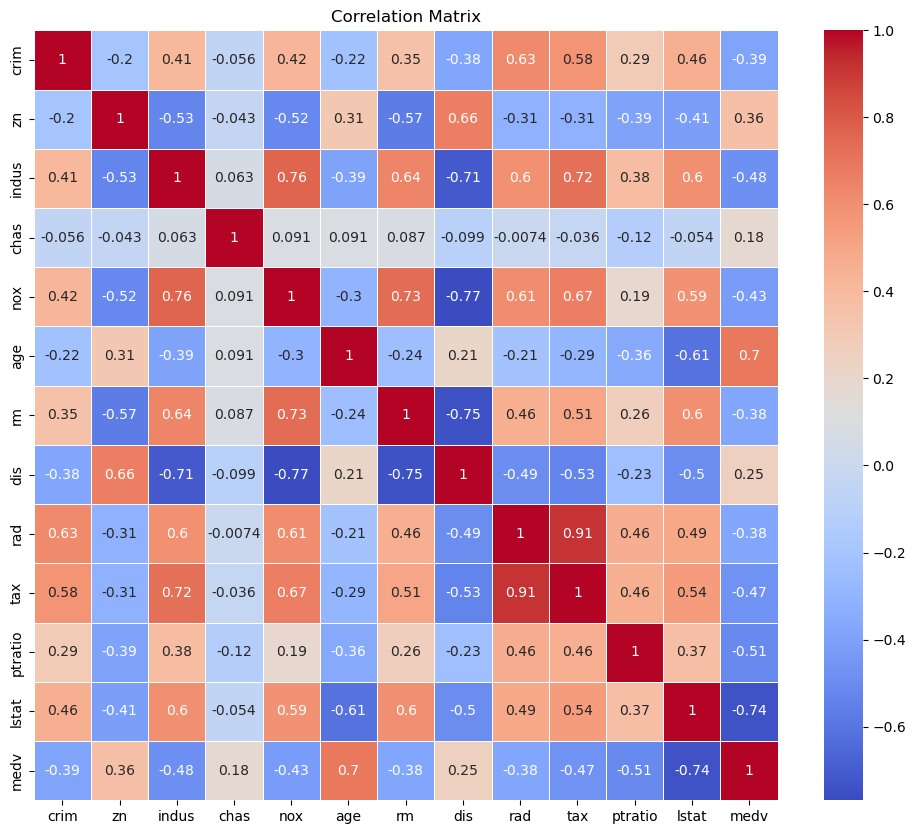

In [30]:
# Correlation matrix heatmap
correlation_matrix = dataset.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

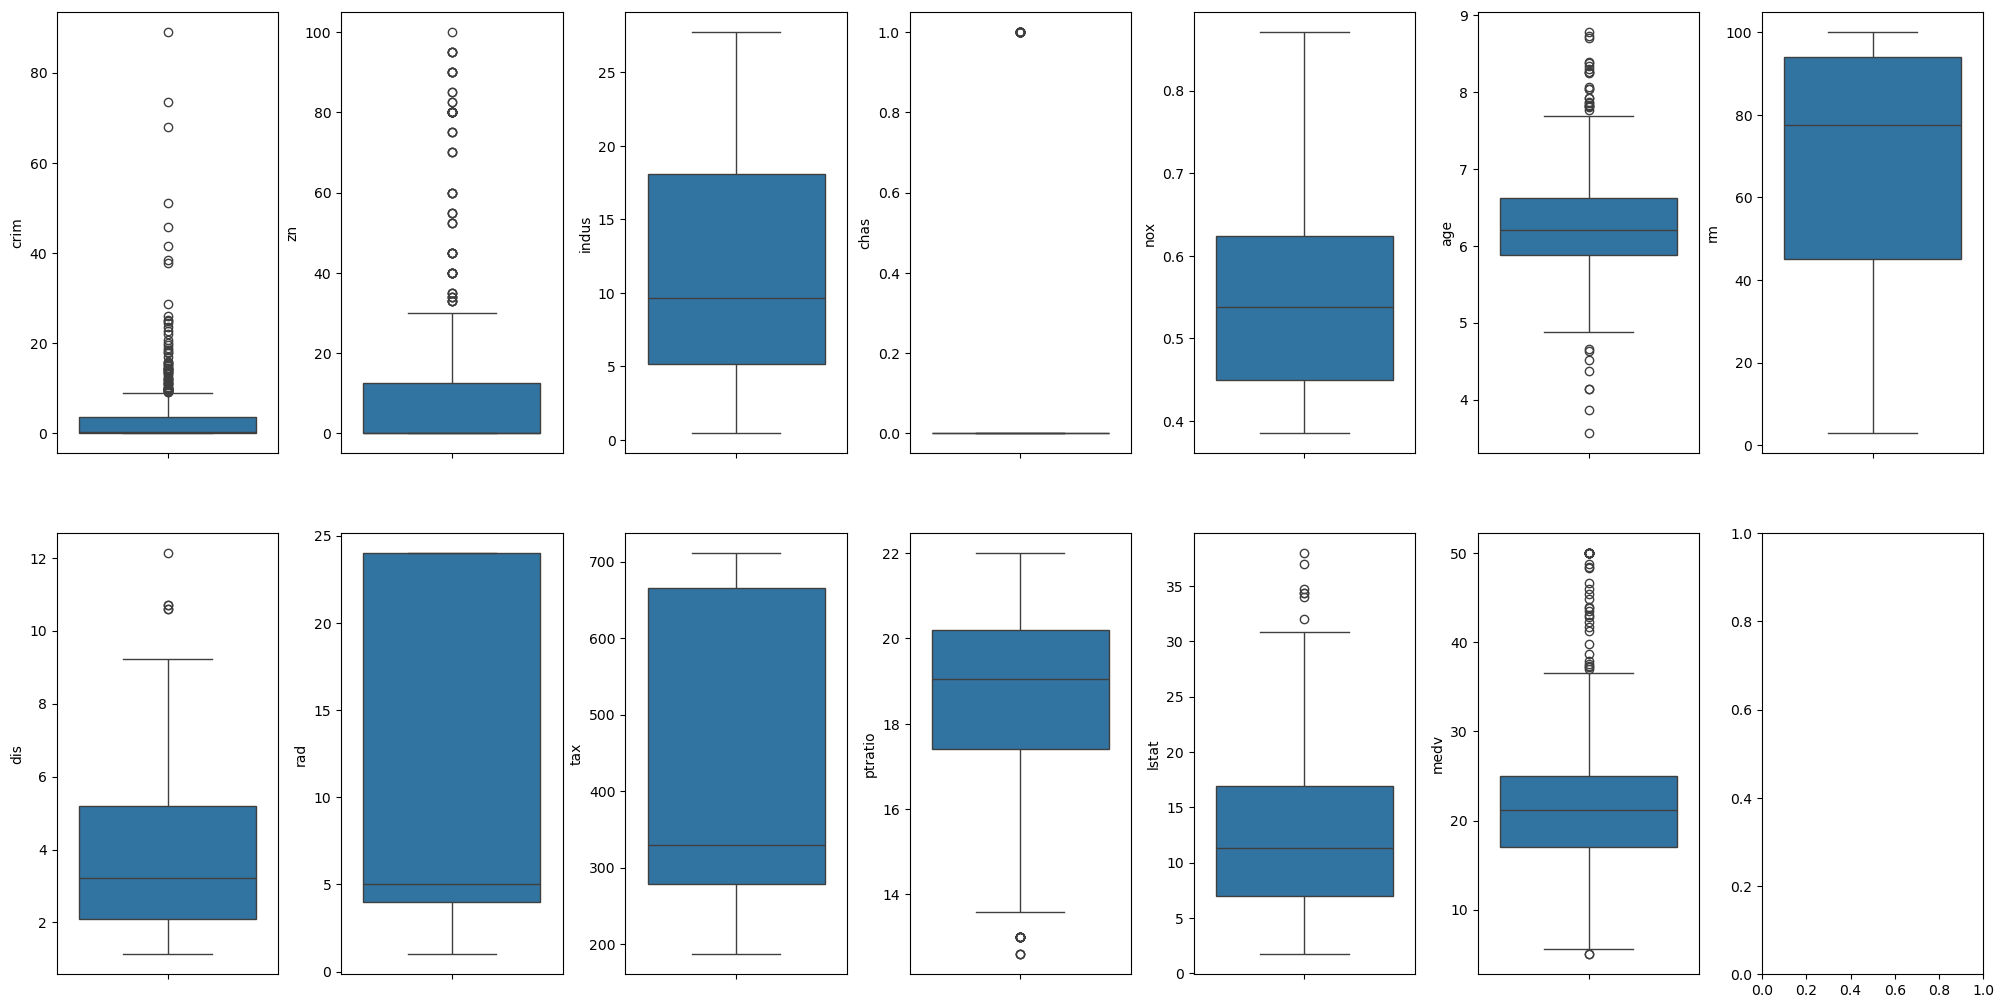

In [32]:
#Checking for outliers
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in dataset.items():
    sns.boxplot(y=k, data=dataset, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Columns like CRIM, ZN, RM, B seems to have outliers. 

Below the percentage of outliers in each column.

In [36]:
for k, v in dataset.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(dataset)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column crim outliers = 13.04%
Column zn outliers = 13.44%
Column indus outliers = 0.00%
Column chas outliers = 100.00%
Column nox outliers = 0.00%
Column age outliers = 5.93%
Column rm outliers = 0.00%
Column dis outliers = 0.99%
Column rad outliers = 0.00%
Column tax outliers = 0.00%
Column ptratio outliers = 2.96%
Column lstat outliers = 1.38%
Column medv outliers = 7.91%


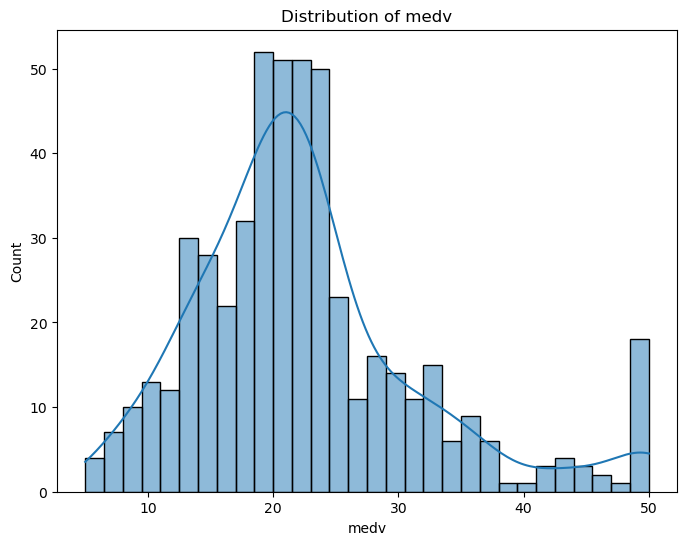

In [38]:
# Distribution of the target variable 'medv'
plt.figure(figsize=(8, 6))
sns.histplot(dataset['medv'], bins=30, kde=True)
plt.title('Distribution of medv')
plt.xlabel('medv')
plt.show()

## Model training

We will train Amazon SageMaker XGBoost on CSV data. It should have the target variable in the first column

In [37]:
dataset = pd.concat([dataset['medv'], dataset.drop(['medv'], axis=1)], axis=1)

In [39]:
#Splitting data
from sklearn.model_selection import train_test_split
training_dataset, validation_dataset = train_test_split(dataset, test_size=0.1)
print(training_dataset.shape,validation_dataset.shape)


(455, 13) (51, 13)


Here, we split our dataset into a training, validation, and testing set. XGBoost will train on the training dataset and use the validation set as data to evaluate prediction results as the model is trained. We will make predictions against the testing set after the model has been deployed.

In [5]:
training_dataset.to_csv('training_dataset.csv', index=False, header=False)
validation_dataset.to_csv('validation_dataset.csv', index=False, header=False)

Now that our dataset is ready, we can upload it to Amazon S3 and take a note of its location so that we can use it for training.

In [6]:
import sagemaker
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'boston-housing'
training_data_path = sess.upload_data(path='training_dataset.csv', key_prefix=prefix + '/input/training')
validation_data_path = sess.upload_data(path='validation_dataset.csv', key_prefix=prefix + '/input/validation')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
2.199.0
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
s3://sagemaker-us-east-1-680363448246/boston-housing/input/training/training_dataset.csv
s3://sagemaker-us-east-1-680363448246/boston-housing/input/validation/validation_dataset.csv


In [7]:
#Pulling XGBoost Docker image from Sagemaker
import boto3
from sagemaker import image_uris
region = boto3.Session().region_name    
container = image_uris.retrieve('xgboost', region, version="latest")
#Creating the xgboost estimator with parameters specified
from sagemaker.estimator import Estimator
role = sagemaker.get_execution_role() 
ll_estimator = Estimator(container,
    role=role, 
    instance_count=1,
    instance_type='ml.m5.large',
    output_path='s3://{}/{}/output'.format(bucket, prefix)
)
ll_estimator.set_hyperparameters(num_round=50, max_depth=5, eta=0.2)

811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


This step kicks off our XGBoost training job. We first define the location of the Amazon SageMaker XGBoost training containers. We then create an Amazon SageMaker estimator. By simply changing values such as instance_count and instance_type...

In [8]:
training_data_channel   = sagemaker.TrainingInput(s3_data=training_data_path, content_type='text/csv')
validation_data_channel = sagemaker.TrainingInput(s3_data=validation_data_path, content_type='text/csv')
ll_data = {'train': training_data_channel, 'validation': validation_data_channel}

Below we fit a Xgboost model with default parameters

In [9]:
#Training the model
ll_estimator.fit(ll_data)

INFO:sagemaker:Creating training-job with name: xgboost-2024-01-07-16-52-23-296


2024-01-07 16:52:23 Starting - Starting the training job...
2024-01-07 16:52:37 Starting - Preparing the instances for training......
2024-01-07 16:53:43 Downloading - Downloading input data......
2024-01-07 16:54:27 Downloading - Downloading the training image..Arguments: train
[2024-01-07:16:55:07:INFO] Running standalone xgboost training.
[2024-01-07:16:55:07:INFO] File size need to be processed in the node: 0.03mb. Available memory size in the node: 252.23mb
[2024-01-07:16:55:07:INFO] Determined delimiter of CSV input is ','
[16:55:07] S3DistributionType set as FullyReplicated
[16:55:07] 455x12 matrix with 5460 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2024-01-07:16:55:07:INFO] Determined delimiter of CSV input is ','
[16:55:07] S3DistributionType set as FullyReplicated
[16:55:07] 51x12 matrix with 612 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[16:55:07] src/tree/updater_prune.cc:74: tree prunin

Now we create a Sagemaker endpoint that will be used for testing the deployed model

In [13]:
from time import strftime, gmtime
timestamp = strftime('%d-%H-%M-%S', gmtime())
endpoint_name = 'xgboost-demo-'+timestamp
print(endpoint_name)

xgboost-demo-07-16-57-16


In [14]:
ll_predictor = ll_estimator.deploy(endpoint_name=endpoint_name, 
                        initial_instance_count=1, 
                        instance_type='ml.t2.medium')

INFO:sagemaker:Creating model with name: xgboost-2024-01-07-16-57-19-125
INFO:sagemaker:Creating endpoint-config with name xgboost-demo-07-16-57-16
INFO:sagemaker:Creating endpoint with name xgboost-demo-07-16-57-16


-------!

After the model is trained and the endpoint is created, this deploys our model to Amazon SageMaker hosting.

Our final step is to make predictions by setuping our serializer.

In [58]:
import random
target_column = 'medv'
random_feature_column = random.choice([col for col in dataset.columns if col != target_column])

# Extract the values from the first row, excluding the target column
test_sample_without_target = dataset.loc[0, dataset.columns != target_column].values
# Create a string in the desired format without the target column
test_sample = ','.join(map(str, test_sample_without_target))
print('Test Sample',test_sample)

Test Sample without 0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,4.98


In [59]:
ll_predictor.serializer = sagemaker.serializers.CSVSerializer()
ll_predictor.deserializer = sagemaker.deserializers.CSVDeserializer()
prediction = ll_predictor.predict(test_sample)
print(prediction[0])

['29.114505767822266']


In [60]:
#Testing using the endpoint call
runtime = boto3.Session().client(service_name='runtime.sagemaker') 
prediction = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                  ContentType='text/csv', 
                                  Body=test_sample)
print(prediction['Body'].read())

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


b'29.114505767822266'


In [23]:
#Deleting the endpoint to free resources
ll_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: xgboost-demo-09-23-48-55
INFO:sagemaker:Deleting endpoint with name: xgboost-demo-09-23-48-55
